# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ndcg_score, f1_score, accuracy_score, recall_score, precision_score, label_ranking_average_precision_score
from sklearn.model_selection import GroupShuffleSplit
import xgboost
from xgboost import XGBRanker
import shap
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

c:\Python\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Read Data + EDA

In [2]:
data = pd.read_csv("intern_task.csv")
data.shape

(235258, 146)

In [4]:
True in list(data.isnull().any()) # Проверка на пропуски

False

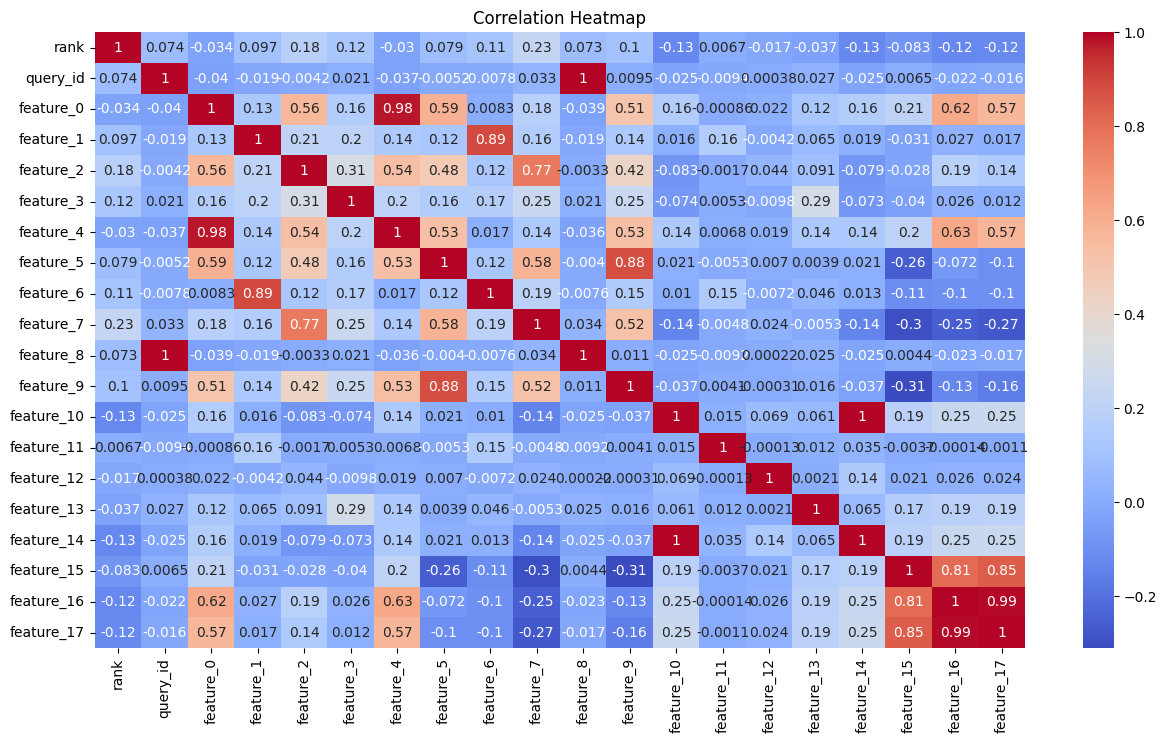

In [3]:
plt.figure(figsize=(15, 8)) 
sns.heatmap(data.iloc[:, :20].corr(), annot=True, cmap='coolwarm') 
plt.title('Correlation Heatmap') 
plt.show()

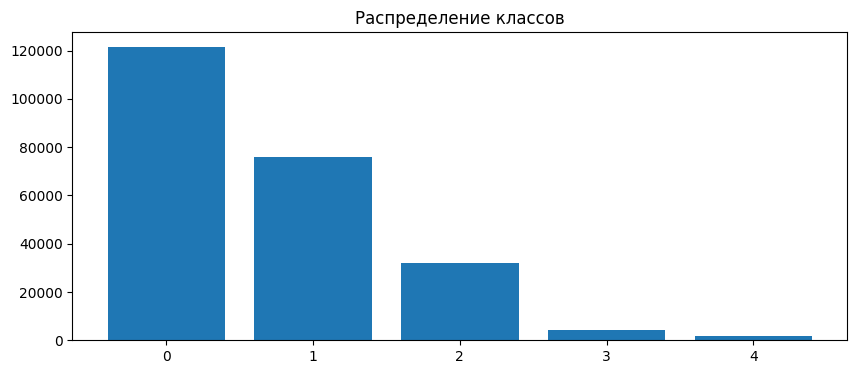

In [4]:
vc = data['rank'].value_counts()
plt.figure(figsize=(10, 4))
plt.bar(vc.index, vc)
plt.title("Распределение классов")
plt.show()

In [5]:
np.unique(data['rank'], return_counts=True)

(array([0, 1, 2, 3, 4], dtype=int64),
 array([121521,  75815,  31910,   4209,   1803], dtype=int64))

# Utils
Так как np.unique(data['rank'], return_counts=True) = (array([0, 1, 2, 3, 4], dtype=int64),
 array([121521,  75815,  31910,   4209,   1803], dtype=int64)), я возьму это соотношения в основу перевода предсказаний модели в дескретные ранги

In [44]:
class0 = round(100*121521/(121521+75815+31910+4209+1803)) - 1
class1 = round(100*75815/(121521+75815+31910+4209+1803)) 
class2 = round(100*31910/(121521+75815+31910+4209+1803))
class3 = round(100*4209/(121521+75815+31910+4209+1803))
class4 = round(100*1803/(121521+75815+31910+4209+1803))

# Функция для расчета Mean Average Precision
def average_precision_score(true_labels, preds):
    order = np.argsort(-preds)
    truths = true_labels[order]
    score = 0.0
    num_hits = 0.0
    for i, p in enumerate(truths):
        if p == max(true_labels):
            num_hits += 1
            score += num_hits / (i + 1.0)
    if num_hits == 0:
        return 0.0
    return score / num_hits

# Функция для расчета Mean Reciprocal Rank
def mean_reciprocal_rank(true_labels, preds):
    order = np.argsort(-preds)
    truths = true_labels[order]
    for index, label in enumerate(truths, 1):
        if label == max(true_labels):
            return 1 / index
    return 0

# Функция для перевода scores в ранги
def assign_ranks(scores, thresholds, diff=0.05):
    if len(scores) == 1:
        return np.array([0])
    ranks = np.zeros_like(scores, dtype=int)
    for i, threshold in enumerate(thresholds):
        if i == 0:
            ranks[scores >= threshold] = i
        elif thresholds[i] - thresholds[i-1] > diff:
            ranks[scores >= threshold] = i
    return ranks

# Функция оценки модели
def eval_model(model, X, y, qid, metric='ndcg'):
    values = []
    for i in range(len(qid.unique())):
        scores = model.predict(X[qid == qid.unique()[i]])
        quantiles = np.percentile(scores, [class0, class0+class1, class0+class1+class2, class0+class1+class2+class3, class0+class1+class2+class3+class4])
        final_ranks = assign_ranks(scores, quantiles)
        if metric == 'ndcg':
            try:
                value = ndcg_score([y[qid == qid.unique()[i]]], [final_ranks], k=5) # Ломается если len() == 1 или 0
            except:
                continue
        elif metric == 'accuracy':
            value = accuracy_score(y[qid == qid.unique()[i]], final_ranks)
        elif metric == 'mrr':
            value = mean_reciprocal_rank(np.array(y[qid == qid.unique()[i]]), np.array(final_ranks))
        elif metric == 'map':
            value = average_precision_score(y[qid == qid.unique()[i]].to_numpy(), final_ranks)
        values.append(value)
    return np.mean(values) 

# Data preproccesing
Датасет делится в соотношение 0.8/0.1/0.1 соответственно для Train, Val, Test выборок

In [69]:
data = pd.read_csv("intern_task.csv")
X = data.drop(['rank', 'query_id'], axis=1)
y = data['rank']
query_ids = data['query_id']

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=1337)
train_idx, temp_idx = next(gss.split(X, y, query_ids))

X_train, X_temp = X.iloc[train_idx], X.iloc[temp_idx]
y_train, y_temp = y.iloc[train_idx], y.iloc[temp_idx]
query_ids_train, query_ids_temp = query_ids.iloc[train_idx], query_ids.iloc[temp_idx]

gss = GroupShuffleSplit(n_splits=1, test_size=0.5, random_state=1337)
val_idx, test_idx = next(gss.split(X_temp, y_temp, query_ids_temp))

X_val, X_test = X.iloc[val_idx], X.iloc[test_idx]
y_val, y_test = y.iloc[val_idx], y.iloc[test_idx]
query_ids_val, query_ids_test = query_ids.iloc[val_idx], query_ids.iloc[test_idx]


# Basic XGB
Для создания baseline модели используются train и test выборки с метрикой NDCG@5

In [22]:
params = {
    'learning_rate': 0.1,
    'booster':'gbtree',
    'objective':'rank:ndcg',
    'device':'cuda',
    'verbosity':0,
    'tree__method':'hist',
}

xgb_base = XGBRanker(**params)
xgb_base.fit(X_train, y_train, qid=query_ids_train)



XGBRanker(base_score=None, booster='gbtree', callbacks=None,
          colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None,
          device='cuda', early_stopping_rounds=None, enable_categorical=False,
          eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
          importance_type=None, interaction_constraints=None, learning_rate=0.1,
          max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
          max_delta_step=None, max_depth=None, max_leaves=None,
          min_child_weight=None, missing=nan, monotone_constraints=None,
          multi_strategy=None, n_estimators=None, n_jobs=None,
          num_parallel_tree=None, random_state=None, ...)

In [27]:
ndcg = eval_model(xgb_base, X_test, y_test, query_ids_test) # NDCG@5 Модели
accuracy = eval_model(xgb_base, X_test, y_test, query_ids_test, 'accuracy')
mrr = eval_model(xgb_base, X_test, y_test, query_ids_test, 'mrr')
mp = eval_model(xgb_base, X_test, y_test, query_ids_test, 'map')
print(f'NDCG@5: {ndcg:.2f}, Accuracy: {accuracy:.2f}, MRR: {mrr:.2f}, MAP: {mp:.2f}')

NDCG@5: 0.61, Accuracy: 0.60, MRR: 0.59, MAP: 0.42


# Hyperparameters tuning
Используются train и val выборки

In [341]:
class0 = round(100*121521/(121521+75815+31910+4209+1803)) - 1
class1 = round(100*75815/(121521+75815+31910+4209+1803)) 
class2 = round(100*31910/(121521+75815+31910+4209+1803))
class3 = round(100*4209/(121521+75815+31910+4209+1803))
class4 = round(100*1803/(121521+75815+31910+4209+1803))

def assign_ranks(scores, thresholds):
    if len(scores) == 1:
        return np.array([0])
    ranks = np.zeros_like(scores, dtype=int)
    for i, threshold in enumerate(thresholds):
        ranks[scores >= threshold] = i
    return ranks

import optuna
from optuna.samplers import TPESampler
start_study = True
def objective(trial):
    params = {
        'grow_policy': trial.suggest_categorical('grow_policy', ["depthwise", "lossguide"]),
        'n_estimators': trial.suggest_int('n_estimators', 400, 1200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5, log=True),
        'gamma': trial.suggest_float('gamma', 1e-8, 0.5),
        'subsample': trial.suggest_float('subsample', 0.3, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
    }
    params["booster"] = "gbtree"
    params["objective"] = "rank:ndcg"
    params["device"] = "cuda"
    params["verbosity"] = 0
    params["tree_method"] = "hist"
    model = XGBRanker(**params)
    model.fit(X_train, y_train, qid=query_ids_train)
    values = []
    for i in range(len(query_ids_val.unique())):
        scores = model.predict(X_val[query_ids_val == query_ids_val.unique()[i]])
        quantiles = np.percentile(scores, [class0, class0+class1, class0+class1+class2, class0+class1+class2+class3, class0+class1+class2+class3+class4])
        final_ranks = assign_ranks(scores, quantiles)
        try:
            ndcg = ndcg_score([y_val[query_ids_val == query_ids_val.unique()[i]]], [final_ranks], k=5)
            values.append(ndcg)
        except:
            continue
    return np.mean(values)    
    

sqlite_db = "sqlite:///xgb_ndcg_mean.db"
study_name = "xgb"

if start_study:
    study = optuna.create_study(storage=sqlite_db, study_name=study_name, 
                                direction="maximize", load_if_exists=True)

    study.optimize(objective, n_trials=100)
    print(f"best optmized ndcg@5: {study.best_value:0.5f}")
    print(f"best hyperparameters: {study.best_params}")

    xgb_params = study.best_params

[I 2024-04-28 20:25:44,170] A new study created in RDB with name: xgb
[I 2024-04-28 20:26:22,550] Trial 0 finished with value: 0.7285642739312146 and parameters: {'grow_policy': 'lossguide', 'n_estimators': 573, 'learning_rate': 0.033151637892379786, 'gamma': 0.4093065717787962, 'subsample': 0.7512274699911479, 'colsample_bytree': 0.3691948420419062, 'max_depth': 13, 'min_child_weight': 2, 'reg_lambda': 3.2867915491051596, 'reg_alpha': 0.17355918146621035}. Best is trial 0 with value: 0.7285642739312146.
[I 2024-04-28 20:26:39,610] Trial 1 finished with value: 0.6094668105160428 and parameters: {'grow_policy': 'depthwise', 'n_estimators': 860, 'learning_rate': 0.022029718767535043, 'gamma': 0.35940297852427555, 'subsample': 0.5706044248826361, 'colsample_bytree': 0.3275544407864402, 'max_depth': 5, 'min_child_weight': 3, 'reg_lambda': 0.017900240993075356, 'reg_alpha': 0.0029690354043882356}. Best is trial 0 with value: 0.7285642739312146.
[I 2024-04-28 20:26:55,864] Trial 2 finished w

best optmized ndcg@5: 0.84596
best hyperparameters: {'grow_policy': 'lossguide', 'n_estimators': 857, 'learning_rate': 0.14909231441416843, 'gamma': 0.019847202542413442, 'subsample': 0.7552655051982914, 'colsample_bytree': 0.5116155017086607, 'max_depth': 11, 'min_child_weight': 1, 'reg_lambda': 0.15802788047611382, 'reg_alpha': 0.000586672168948868}


# Final model
Для финальной оценки используется test выборка, которую модель еще не видела.

In [20]:
xgb_params = {
    'grow_policy': 'lossguide', 
    'n_estimators': 857, 
    'learning_rate': 0.14909231441416843, 
    'gamma': 0.019847202542413442, 
    'subsample': 0.7552655051982914, 
    'colsample_bytree': 0.5116155017086607, 
    'max_depth': 11, 
    'min_child_weight': 1, 
    'reg_lambda': 0.15802788047611382, 
    'reg_alpha': 0.000586672168948868,
    'booster':'gbtree',
    'objective':'rank:ndcg',
    'device':'cuda',
    'verbosity':0,
    'tree__method':'hist',
    }

xgb = XGBRanker(**xgb_params)
xgb.fit(X_train, y_train, qid=query_ids_train)

XGBRanker(base_score=None, booster='gbtree', callbacks=None,
          colsample_bylevel=None, colsample_bynode=None,
          colsample_bytree=0.5116155017086607, device='cuda',
          early_stopping_rounds=None, enable_categorical=False,
          eval_metric=None, feature_types=None, gamma=0.019847202542413442,
          grow_policy='lossguide', importance_type=None,
          interaction_constraints=None, learning_rate=0.14909231441416843,
          max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
          max_delta_step=None, max_depth=11, max_leaves=None,
          min_child_weight=1, missing=nan, monotone_constraints=None,
          multi_strategy=None, n_estimators=857, n_jobs=None,
          num_parallel_tree=None, random_state=None, ...)

In [28]:
ndcg = eval_model(xgb, X_test, y_test, query_ids_test)
accuracy = eval_model(xgb, X_test, y_test, query_ids_test, 'accuracy')
mrr = eval_model(xgb, X_test, y_test, query_ids_test, 'mrr')
mp = eval_model(xgb_base, X_test, y_test, query_ids_test, 'map')
print(f'NDCG@5: {ndcg:.2f}, Accuracy: {accuracy:.2f}, MRR: {mrr:.2f}, MAP: {mp:.2f}')

NDCG@5: 0.84, Accuracy: 0.63, MRR: 0.90, MAP: 0.42


In [63]:
preds = []
for i in range(len(query_ids_test.unique())):
    scores = xgb.predict(X_test[query_ids_test == query_ids_test.unique()[i]])
    quantiles = np.percentile(scores, [class0, class0+class1, class0+class1+class2, class0+class1+class2+class3, class0+class1+class2+class3+class4])
    final_ranks = assign_ranks(scores, quantiles)
    preds.extend(final_ranks)

In [74]:
submission = pd.DataFrame(
    {
        'True': y_test.to_numpy(),
        'Pred': preds,
     }
)

# Post hoc анализ при помощи shap

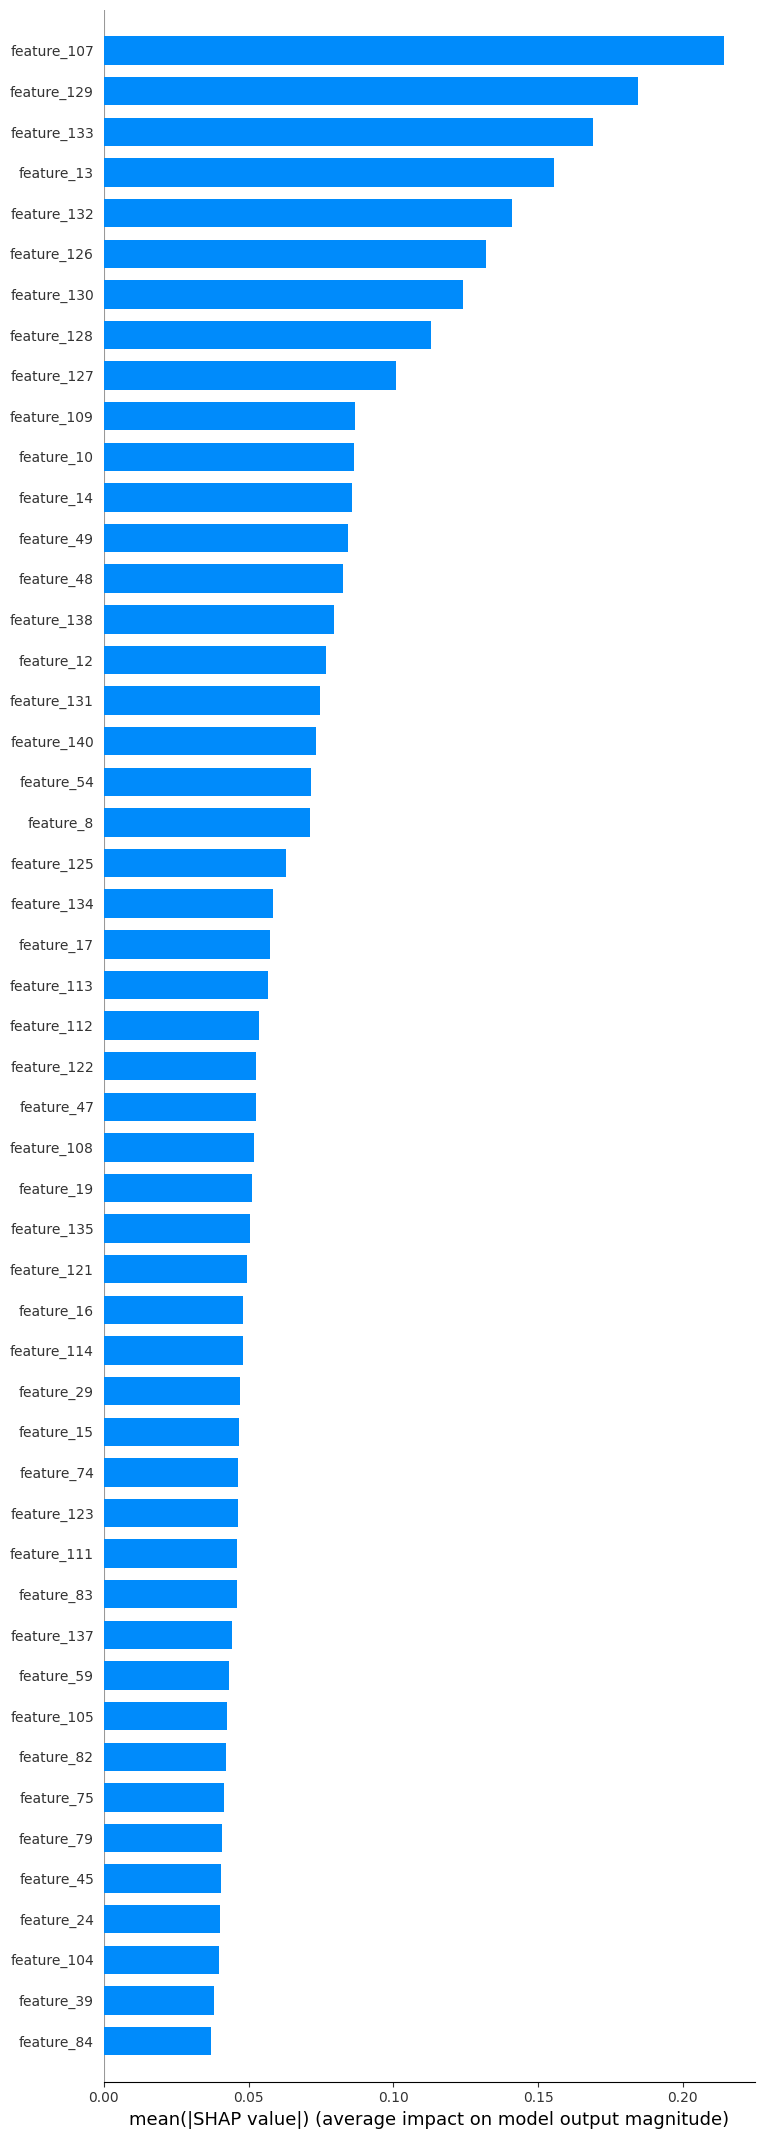

In [32]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=50, show=False)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [43]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])